In [6]:
import pandas as pd
import numpy as np
import pandas_ta as pta
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, Dense, Flatten, Reshape
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import CSVLogger, ModelCheckpoint
from sklearn.cluster import AgglomerativeClustering, KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

plt.style.use('seaborn-v0_8-whitegrid')

plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False 


In [11]:
tickers = [
    # 반도체
    '005930', # 삼성전자
    '000660', # SK하이닉스
    # 2차전지
    '373220', # LG에너지솔루션
    '006400', # 삼성SDI
    '003670', # 포스코퓨처엠
    # 자동차
    '005380', # 현대차
    '000270', # 기아
    # 플랫폼/IT
    '035420', # NAVER
    '035720', # 카카오
    # 바이오/헬스케어
    '207940', # 삼성바이오로직스
    '068270', # 셀트리온
    # 금융
    '105560', # KB금융
    '055550', # 신한지주
    # 화학/중공업
    '051910', # LG화학
    '012330', # 현대모비스
    '042670', # 한화오션
    # 소비재/유통
    '008770', # 호텔신라
    '139480', # 이마트
    # 통신 & 유틸리티
    '017670', # SK텔레콤
    '015760', # 한국전력
]

start_date = '2022-01-01'
end_date = '2025-08-01'

all_data = {}
krx_list = fdr.StockListing('KRX')

krx_list.set_index('Code', inplace=True)
# ---------------------------

print("📈 코스피 종목 데이터 수집을 시작합니다...")
for ticker in tickers:
    stock_name = krx_list.loc[ticker, 'Name']
    
    df = fdr.DataReader(ticker, start_date, end_date)
    
    rename_dict = {'Open': 'PX_OPEN', 'High': 'PX_HIGH', 'Low': 'PX_LOW', 'Close': 'PX_LAST', 'Volume': 'PX_VOLUME'}
    df.rename(columns=rename_dict, inplace=True)
    
    if 'Change' in df.columns:
        df = df.drop(columns='Change')
        
    all_data[stock_name] = df
    print(f"- {stock_name} ({ticker}) 데이터 수집 완료")

data = pd.concat(all_data, axis=1, keys=all_data.keys())
data.index.name = 'Dates'
data.columns.names = ['Ticker', 'Feature']

print("데이터 준비 완료")
data.head()

📈 코스피 종목 데이터 수집을 시작합니다...
- 삼성전자 (005930) 데이터 수집 완료
- SK하이닉스 (000660) 데이터 수집 완료
- LG에너지솔루션 (373220) 데이터 수집 완료
- 삼성SDI (006400) 데이터 수집 완료
- 포스코퓨처엠 (003670) 데이터 수집 완료
- 현대차 (005380) 데이터 수집 완료
- 기아 (000270) 데이터 수집 완료
- NAVER (035420) 데이터 수집 완료
- 카카오 (035720) 데이터 수집 완료
- 삼성바이오로직스 (207940) 데이터 수집 완료
- 셀트리온 (068270) 데이터 수집 완료
- KB금융 (105560) 데이터 수집 완료
- 신한지주 (055550) 데이터 수집 완료
- LG화학 (051910) 데이터 수집 완료
- 현대모비스 (012330) 데이터 수집 완료
- HD현대인프라코어 (042670) 데이터 수집 완료
- 호텔신라 (008770) 데이터 수집 완료
- 이마트 (139480) 데이터 수집 완료
- SK텔레콤 (017670) 데이터 수집 완료
- 한국전력 (015760) 데이터 수집 완료

✅ 데이터 준비 완료!


Ticker        삼성전자                                   SK하이닉스                  \
Feature    PX_OPEN PX_HIGH PX_LOW PX_LAST PX_VOLUME PX_OPEN PX_HIGH  PX_LOW   
Dates                                                                         
2022-01-03   79400   79800  78200   78600  13502112  132000  132500  128000   
2022-01-04   78800   79200  78300   78700  12427416  129500  130000  127500   
2022-01-05   78800   79000  76400   77400  25470640  129000  129000  121500   
2022-01-06   76700   77600  76600   76900  12931954  123500  127000  123000   
2022-01-07   78100   78400  77400   78300  15163757  127000  129000  126500   

Ticker                        ...   SK텔레콤                                   \
Feature    PX_LAST PX_VOLUME  ... PX_OPEN PX_HIGH PX_LOW PX_LAST PX_VOLUME   
Dates                         ...                                            
2022-01-03  128500   3782213  ...   57600   57900  56300   57200    754362   
2022-01-04  128500   3622369  ...   57000   57200  56300   57200    957080   
2022-01-05  125500   7414954  ...   56900   58900  56800   58300   1213826   
2022-01-06  125000   3725569  ...   58200   58900  57600   57900    953429   
2022-01-07  127000   3270119  ...   57400   57900  56000   56400    921007   

Ticker        한국전력                                   
Feature    PX_OPEN PX_HIGH PX_LOW PX_LAST PX_VOLUME  
Dates                                                
2022-01-03   22350   22450  22100   22350   1211491  
2022-01-04   22250   22250  21850   22000   1716725  
2022-01-05   21850   21900  21650   21800   1563585  
2022-01-06   21600   21750  21400   21450   1544853  
2022-01-07   21450   21700  21350   21650    896229  

[5 rows x 100 columns]

In [12]:
indices = list(data.columns.get_level_values(0).unique())
index_dict = {}
print("📊 기술적 지표 계산 및 데이터 정규화를 시작합니다...")

for index in indices:
    df = data[index].copy()
    rename_dict = {'PX_OPEN': 'open', 'PX_HIGH': 'high', 'PX_LOW': 'low', 'PX_LAST': 'close', 'PX_VOLUME': 'volume'}
    df.rename(columns=rename_dict, inplace=True)

    df.dropna(subset=['open', 'high', 'low', 'close', 'volume'], inplace=True)
    if df.empty or df['volume'].isnull().all() or (df['volume'] == 0).all(): continue
    df['volume'] = df['volume'].astype('int64')

    df.ta.rsi(append=True)
    df.ta.mfi(append=True)
    df.ta.adx(append=True)
    df.ta.obv(append=True)
    df.ta.atr(append=True)
    df.ta.ema(length=14, append=True)
    
    bbands = df.ta.bbands(length=20, append=False)
    if bbands is not None and not bbands.empty:
        df['Boll_upper'] = bbands[f'BBU_20_2.0']
        df['Boll_mid'] = bbands[f'BBM_20_2.0']
        df['Boll_lower'] = bbands[f'BBL_20_2.0']

    macd = df.ta.macd(fast=14, slow=30, append=False)
    if macd is not None and not macd.empty:
        df['MACD'] = macd[f'MACD_14_30_9']
    
    if 'close' in df.columns:
        for i in range(1, 49):
            df[f'LR_{i}'] = np.log(df['close']) - np.log(df['close'].shift(i))
    
    df.dropna(inplace=True, axis=0)
    if df.empty: continue
            
    # 0-1 정규화 (Min-Max Scaling)
    for col in df.columns:
        min_val, max_val = df[col].min(), df[col].max()
        if max_val - min_val > 0:
            df[col] = (df[col] - min_val) / (max_val - min_val)
        else:
            df[col] = 0
            
    index_dict[index] = df

print("✅ 모든 종목의 특징 생성 및 정규화 완료!")

📊 기술적 지표 계산 및 데이터 정규화를 시작합니다...


/var/folders/8l/4_fpxyr51vdgqv070yhckk540000gn/T/ipykernel_20639/732415563.py:16: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[1.18327850e+12 1.03962097e+12 8.69406341e+11 1.55412565e+12
 1.31015190e+12 9.42022516e+11 8.63427395e+11 7.22261285e+11
 1.33627628e+12 8.03605908e+11 1.02085716e+12 9.49886646e+11
 8.96998769e+11 9.62453871e+11 1.50160130e+12 7.14337650e+11
 1.25818226e+12 8.76127100e+11 9.59403181e+11 5.86780286e+11
 1.18695968e+12 8.73897833e+11 8.71485223e+11 1.74602600e+12
 9.46995153e+11 9.59705133e+11 7.81589847e+11 9.62341581e+11
 7.95041163e+11 1.05633945e+12 1.12326787e+12 8.23861284e+11
 9.31886393e+11 7.58849593e+11 9.61769987e+11 5.50659065e+11
 1.42864825e+12 1.35815642e+12 1.06921192e+12 8.01599850e+11
 1.01025762e+12 8.17924877e+11 1.23103823e+12 9.00926517e+11
 7.69949570e+11 1.10930078e+12 1.28050538e+12 1.02427593e+12
 7.55509789e+11 6.31754652e+11 4.05508569e+11 4.51217448e

✅ 모든 종목의 특징 생성 및 정규화 완료!


In [13]:
index_keys = list(index_dict.keys())
for index in index_keys:
    if index_dict[index].empty:
        del index_dict[index]
indices = list(index_dict.keys())

min_len = min(len(df) for df in index_dict.values())
print(f"📏 모든 데이터 길이를 {min_len}으로 통일합니다.")
trimmed_index_dict = {index: df.tail(min_len) for index, df in index_dict.items()}

n_timesteps = min_len
n_features = trimmed_index_dict[indices[0]].shape[1]
n_indices = len(indices)
x_data = np.array([df.values for df in trimmed_index_dict.values()])

x = x_data.reshape(n_indices, n_timesteps, n_features, 1).astype('float32')

print(f"🧠 모델 입력 데이터(x) 형태: {x.shape}")

📏 모든 데이터 길이를 811으로 통일합니다.
🧠 모델 입력 데이터(x) 형태: (20, 811, 65, 1)


In [14]:
args = {
    'n_clusters': 7,
    'batch_size': 16,
    'epochs': 50,
    'save_dir': 'results'
}
if not os.path.exists(args['save_dir']):
    os.makedirs(args['save_dir'])

input_shape = x.shape[1:]
filters = [32, 64, 128, 10]

# --- 인코더 (Encoder): 특징 압축 ---
encoder_input = Input(shape=input_shape, name='encoder_input')
x_enc = Conv2D(filters[0], 5, padding='same', activation='relu')(encoder_input)
x_enc = Conv2D(filters[1], 5, padding='same', activation='relu')(x_enc)
conv3_output = Conv2D(filters[2], 3, padding='valid', activation='relu')(x_enc)
flatten_output = Flatten()(conv3_output)
embedding = Dense(units=filters[3], name='embedding')(flatten_output)
encoder = Model(encoder_input, embedding, name='encoder')

# --- 디코더 (Decoder): 특징 복원 ---
decoder_input = Input(shape=(filters[3],), name='decoder_input')
x_dec = Dense(units=flatten_output.shape[1], activation='relu')(decoder_input)
x_dec = Reshape(conv3_output.shape[1:])(x_dec)
x_dec = Conv2DTranspose(filters[1], 3, padding='valid', activation='relu')(x_dec)
x_dec = Conv2DTranspose(filters[0], 5, padding='same', activation='relu')(x_dec)
decoder_output = Conv2DTranspose(input_shape[2], 5, padding='same')(x_dec)
decoder = Model(decoder_input, decoder_output, name='decoder')

# --- 오토인코더 모델 결합 ---
autoencoder = Model(encoder.input, decoder(encoder.output), name='autoencoder')

print("✅ 오토인코더 모델을 성공적으로 구축했습니다.")
autoencoder.summary()

✅ 오토인코더 모델을 성공적으로 구축했습니다.


Model: "autoencoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ encoder_input (InputLayer)      │ (None, 811, 65, 1)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 811, 65, 32)    │           832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 811, 65, 64)    │        51,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 809, 63, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 6523776)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Dense)               │ (None, 10)             │    65,237,770 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ decoder (Functional)            │ (None, 811, 65, 1)     │    71,887,361 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 137,251,083 (523.57 MB)

 Trainable params: 137,251,083 (523.57 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
autoencoder.compile(optimizer='adam', loss='mse')

csv_logger = CSVLogger(os.path.join(args['save_dir'], 'pretrain-log.csv'))
model_checkpoint = ModelCheckpoint(
    filepath=os.path.join(args['save_dir'], 'best_model.keras'), 
    monitor='loss', 
    save_best_only=True
)

print("\n🔥 모델 학습을 시작합니다... (약 5~15분 소요될 수 있습니다)")
autoencoder.fit(x, x, 
                batch_size=args['batch_size'], 
                epochs=args['epochs'], 
                verbose=1, 
                callbacks=[csv_logger, model_checkpoint])
print('✅ 학습 완료!')


🔥 모델 학습을 시작합니다... (약 5~15분 소요될 수 있습니다)
Epoch 1/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 38s 17s/step - loss: 0.2262
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - loss: 3.0462
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 19s/step - loss: 0.2191
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 18s/step - loss: 0.1937
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 37s 15s/step - loss: 0.1350
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 36s 19s/step - loss: 0.0877
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 18s/step - loss: 0.0533
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 16s/step - loss: 0.0484
Epoch 9/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 32s 15s/step - loss: 0.0411
Epoch 10/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 34s 17s/step - loss: 0.0341
Epoch 11/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 22s 5s/step - loss: 0.0344
Epoch 12/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 35s 15s/step - loss: 0.0321
Epoch 13/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 45s 21s/step - loss: 0.0302
Epoch 14/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 33s 6s/step - loss: 0.0304
Epoch 15/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 5s/step - loss: 0.030

In [16]:
print("\n[딥러닝 방식] 특징 벡터 추출 및 클러스터링...")
features_ae = encoder.predict(x)
agg_clustering = AgglomerativeClustering(n_clusters=args['n_clusters'])
pred_ae = agg_clustering.fit_predict(features_ae)
cluster_df_ae = pd.DataFrame({'종목명': indices, '클러스터': pred_ae})

print("[고전 방식] PCA 차원 축소 및 클러스터링...")
feature_list = [df.values.flatten() for df in trimmed_index_dict.values()]
X_features = np.array(feature_list)
pca = PCA(n_components=10, random_state=42)
features_pca = pca.fit_transform(X_features)
kmeans = KMeans(n_clusters=args['n_clusters'], random_state=42, n_init='auto')
pred_pca = kmeans.fit_predict(features_pca)
cluster_df_pca = pd.DataFrame({'종목명': indices, '클러스터': pred_pca})


# --- 결과 출력 ---
print("\n" + "="*50)
print("     💻 딥러닝 Autoencoder 방식 클러스터링 결과 💻")
print("="*50)
for i in sorted(cluster_df_ae['클러스터'].unique()):
    cluster_indices = cluster_df_ae[cluster_df_ae['클러스터'] == i]['종목명'].values
    print(f'--- 클러스터 {i} ---\n{list(cluster_indices)}\n')

print("\n" + "="*50)
print("     💿 고전 PCA + K-Means 방식 클러스터링 결과 💿")
print("="*50)
for i in sorted(cluster_df_pca['클러스터'].unique()):
    cluster_indices = cluster_df_pca[cluster_df_pca['클러스터'] == i]['종목명'].values
    print(f'--- 클러스터 {i} ---\n{list(cluster_indices)}\n')

# 성능 평가
silhouette_ae = silhouette_score(features_ae, pred_ae)
silhouette_pca = silhouette_score(features_pca, pred_pca)

print("\n" + "="*50)
print("     💯 성능 평가 (실루엣 점수) 💯")
print("="*50)
print(f"딥러닝 방식 실루엣 점수: {silhouette_ae:.4f}")
print(f"고전 방식(PCA) 실루엣 점수: {silhouette_pca:.4f}")

if silhouette_ae > silhouette_pca:
    print("\n💡 결론: 딥러닝 방식의 군집 분리 성능이 더 우수합니다.")
else:
    print("\n💡 결론: 고전 방식(PCA)의 군집 분리 성능이 더 우수합니다.")


[딥러닝 방식] 특징 벡터 추출 및 클러스터링...
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
[고전 방식] PCA 차원 축소 및 클러스터링...

     💻 딥러닝 Autoencoder 방식 클러스터링 결과 💻
--- 클러스터 0 ---
['SK하이닉스', '삼성SDI', '호텔신라']

--- 클러스터 1 ---
['현대차', '삼성바이오로직스', '셀트리온', '이마트']

--- 클러스터 2 ---
['기아', 'NAVER', 'KB금융', 'LG화학', '현대모비스', 'HD현대인프라코어']

--- 클러스터 3 ---
['한국전력']

--- 클러스터 4 ---
['삼성전자', 'SK텔레콤']

--- 클러스터 5 ---
['LG에너지솔루션', '포스코퓨처엠', '신한지주']

--- 클러스터 6 ---
['카카오']


     💿 고전 PCA + K-Means 방식 클러스터링 결과 💿
--- 클러스터 0 ---
['NAVER', '카카오', '호텔신라', '이마트', 'SK텔레콤']

--- 클러스터 1 ---
['KB금융', '신한지주', '한국전력']

--- 클러스터 2 ---
['LG에너지솔루션', '삼성SDI', '포스코퓨처엠', 'LG화학']

--- 클러스터 3 ---
['SK하이닉스', '현대모비스', 'HD현대인프라코어']

--- 클러스터 4 ---
['삼성전자']

--- 클러스터 5 ---
['현대차', '기아']

--- 클러스터 6 ---
['삼성바이오로직스', '셀트리온']


     💯 성능 평가 (실루엣 점수) 💯
딥러닝 방식 실루엣 점수: 0.5258
고전 방식(PCA) 실루엣 점수: 0.2577

💡 결론: 딥러닝 방식의 군집 분리 성능이 더 우수합니다.


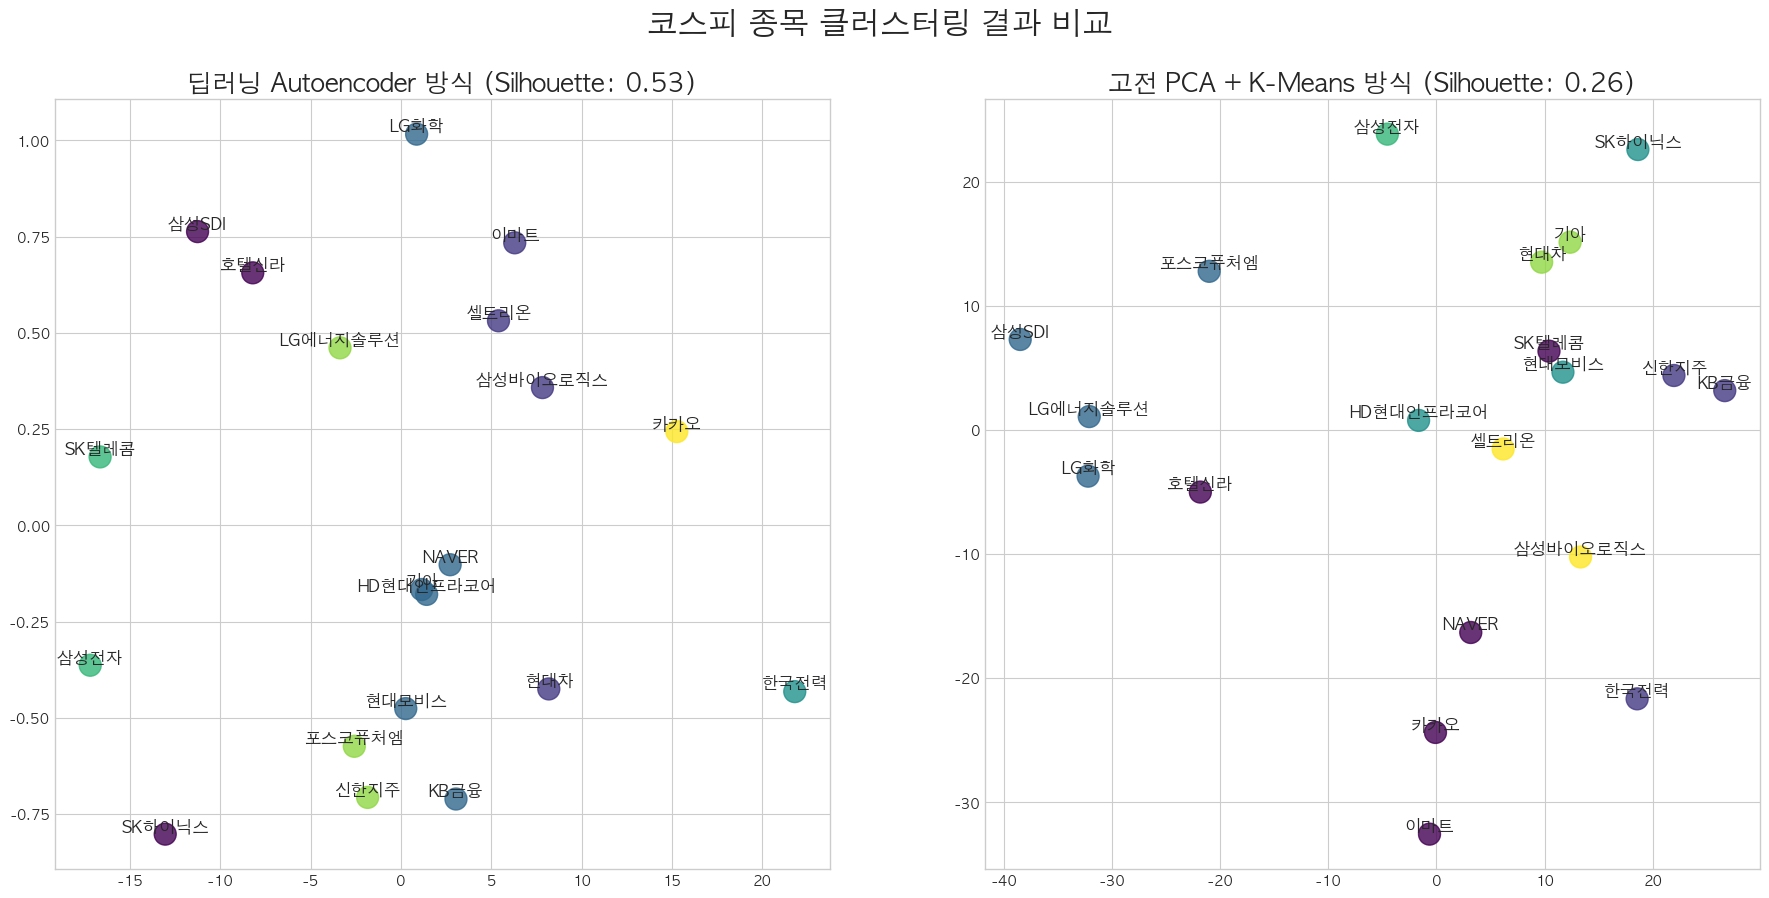

In [17]:
# 시각화를 위해 2차원으로 차원 축소
pca_2d = PCA(n_components=2, random_state=42)
features_ae_2d = pca_2d.fit_transform(features_ae)
features_pca_2d = pca_2d.fit_transform(features_pca)

fig, axes = plt.subplots(1, 2, figsize=(22, 10))
fig.suptitle('코스피 종목 클러스터링 결과 비교', fontsize=22, y=0.97)

# 딥러닝(오토인코더) 결과 시각화
axes[0].set_title(f'딥러닝 Autoencoder 방식 (Silhouette: {silhouette_ae:.2f})', fontsize=18)
scatter1 = axes[0].scatter(features_ae_2d[:, 0], features_ae_2d[:, 1], c=pred_ae, cmap='viridis', s=250, alpha=0.8)
for i, txt in enumerate(indices):
    axes[0].annotate(txt, (features_ae_2d[i, 0], features_ae_2d[i, 1]), fontsize=12, ha='center', va='bottom')

# 고전(PCA) 결과 시각화
axes[1].set_title(f'고전 PCA + K-Means 방식 (Silhouette: {silhouette_pca:.2f})', fontsize=18)
scatter2 = axes[1].scatter(features_pca_2d[:, 0], features_pca_2d[:, 1], c=pred_pca, cmap='viridis', s=250, alpha=0.8)
for i, txt in enumerate(indices):
    axes[1].annotate(txt, (features_pca_2d[i, 0], features_pca_2d[i, 1]), fontsize=12, ha='center', va='bottom')

plt.show()